# Resize Operator

This notebook demonstrates the usage of the Resize operator.

Resize operator resamples images, volumes* and sequences of images. It can be parameterized with respect to how the final output size is calculated and what kind of filtering or interpolation method is applied. It also supports resizing regions of interest (RoI).

<div class="alert alert-info">

   Note<br>
   
   `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.
   
</div>

<div class="alert alert-info">

   Note<br>
   
   For detailed description of filtering methods, see "Interpolation methods" tutorial.
   
</div>

_\* You can see Resize applied to volumetric data in 3D transforms tutorial._

In [1]:
import math
import os
from pathlib import Path

import PIL.Image
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import nvidia.dali.experimental.dynamic as ndd
import nvidia.dali.types as types

test_data_root = Path(os.environ["DALI_EXTRA_PATH"])
db_folder = test_data_root / "db" / "lmdb"

reader = ndd.readers.Caffe(path=db_folder, random_shuffle=True, seed=1234)
idx = 5  # adjust to see other images
file, label = next(reader.next_epoch(batch_size=idx + 1))
image = ndd.decoders.image(file, device="gpu").select(idx)

## Visualization Helpers

In [2]:
def show_images(
    *images: ndd.Tensor,
    size: tuple[int, int],
    labels: list[str] | None = None,
    columns: int = 2,
):
    fig = plt.figure(figsize=size)
    rows = int(math.ceil(len(images) / columns))
    gs = gridspec.GridSpec(rows, columns)
    for i, img in enumerate(images):
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title(labels[i] if labels is not None else "")
        plt.imshow(img.cpu() / 255.0)
    plt.show()

## Output Size Parameters

There are several ways to define how the image is resized. The simplest way is to specify the desired output size explicitly:

1. Use `size` argument - can be a scalar (all extents equal), a list/tuple (sizes per-dimension), or a `Batch`
2. Use separate arguments `resize_x`, `resize_y` - can be Python scalars or `Batch` for per-sample sizes

If an extent for any dimension is missing (0 or not specified), it's selected to maintain the aspect ratio.

In our first example, we'll use the default scaling mode (see section about scaling modes for details).

Original image


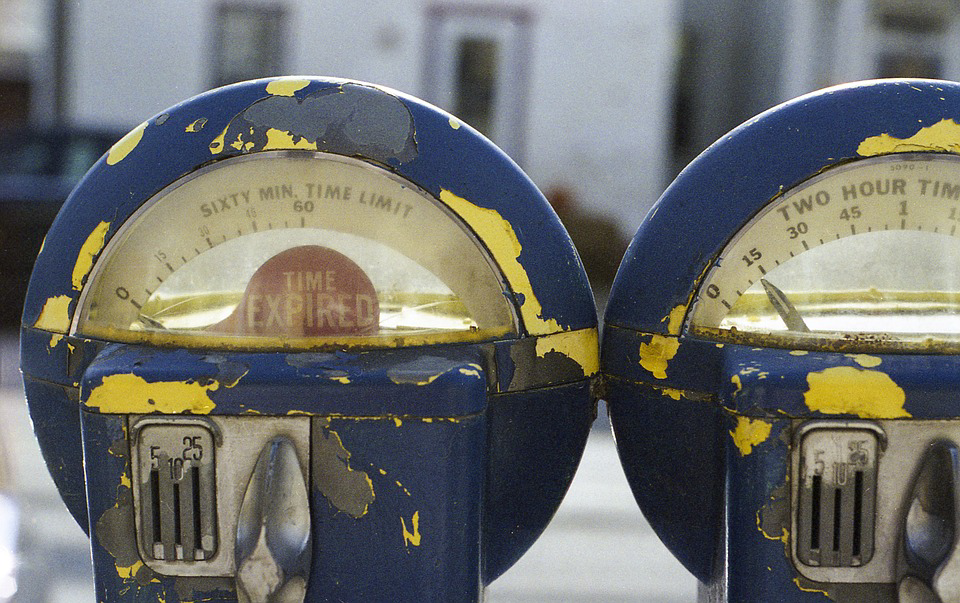

In [3]:
print("Original image")
PIL.Image.fromarray(np.asarray(image.cpu()))

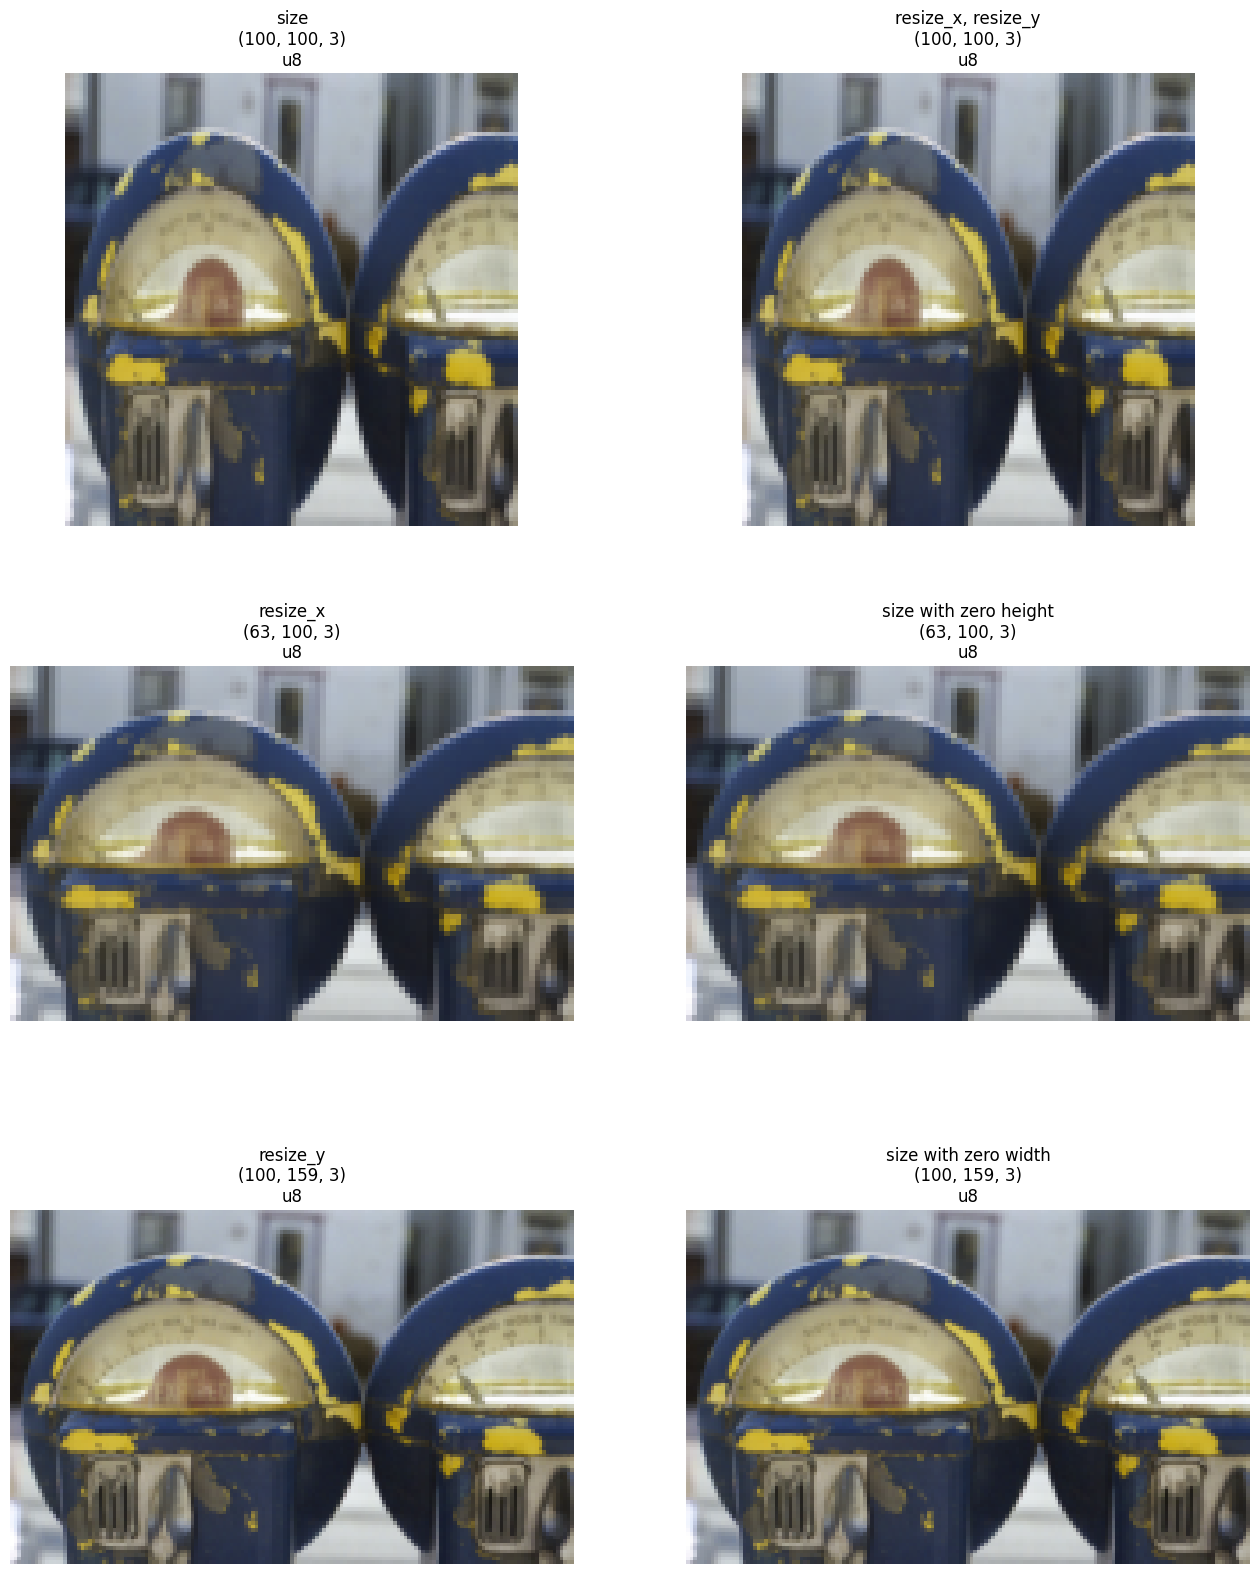

In [4]:
width = 100
height = 100

images = [
    ndd.resize(image, size=[height, width]),
    ndd.resize(image, resize_x=width, resize_y=height),
    ndd.resize(image, resize_x=width),
    ndd.resize(image, size=[0, width]),
    ndd.resize(image, resize_y=height),
    ndd.resize(image, size=[height, 0]),
]

labels = [
    "size",
    "resize_x, resize_y",
    "resize_x",
    "size with zero height",
    "resize_y",
    "size with zero width",
]
for i, img in enumerate(images):
    labels[i] += "\n{}".format(img.shape)
    labels[i] += "\n{}".format(img.dtype)
show_images(*images, size=(16, 20), labels=labels)

## Scaling Modes

Resize supports four resize modes:

- **"default"** - the specified dimensions are scaled to the requested size; missing extents are calculated by applying the average scale of provided extents (for 2D with one extent, this preserves aspect ratio)
- **"stretch"** - the specified dimensions are scaled to the requested size; missing ones are not scaled at all
- **"not_larger"** - the image is scaled so that no dimension exceeds the specified size; aspect ratio is preserved
- **"not_smaller"** - the image is scaled so that no dimension is smaller than specified (`max_size` can limit upscaling of high aspect ratio inputs)

<div class="alert alert-info">

   Legacy Scaling Modes<br>
   
   `resize_shorter` and `resize_longer` work as if the same size was specified for all axes with mode set to "not_smaller" and "not_larger", respectively
   
</div>

In [5]:
width = 200
height = 100

images = [
    ndd.resize(image, size=[height, width]),
    ndd.resize(image, resize_x=width),
    ndd.resize(image, resize_y=height),
    ndd.resize(image, size=[height, width], mode="stretch"),
    ndd.resize(image, resize_x=width, mode="stretch"),
    ndd.resize(image, resize_y=height, mode="stretch"),
    ndd.resize(image, size=[height, width], mode="not_larger"),
    ndd.resize(image, size=[height, width], mode="not_smaller"),
    ndd.resize(image, size=[height, width], mode="not_smaller", max_size=[110, 200]),
]

In [6]:
labels = [
    "default, width and height",
    "default, width",
    "default, height",
    "stretch, width and height",
    "stretch, width",
    "stretch, height",
    "not_larger",
    "not_smaller",
    "not_smaller, max_size\n(note that size is limited compared to pure not_smaller)",
]
for i, img in enumerate(images):
    labels[i] += "\n{}".format(img.shape)
show_images(*images, size=(16, 16), labels=labels, columns=3)

## Region of Interest (RoI) Processing

If only a part of the input image should be scaled, it can be specified using `roi_start` and `roi_end` parameters. RoI can be in absolute (pixel) coordinates or relative (0..1) if `roi_relative=True`.

In [7]:
cx = 270
cy = 190
images = (
    ndd.resize(
        image,
        size=[100, 100],
        roi_start=[cy - r, cx - r],
        roi_end=[cy + r, cx + r],
    )
    for r in [100, 50, 30, 10]
)

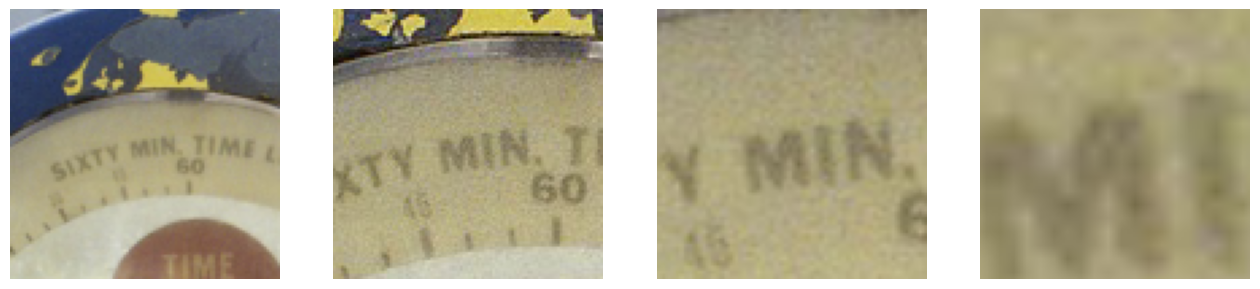

In [8]:
show_images(*images, size=(16, 4), columns=4)

### Flipping with RoI

If `roi_end[d] > roi_start[d]` the image is flipped in dimension *d*.

### Out-of-bounds and Degenerate Coordinates

Out-of-bounds input coordinates are clamped, resulting in repeating the border pixels. If the RoI is degenerate (has zero extent), resize will broadcast the source image sampled at the RoI coordinate along the degenerate axis.

In [9]:
width = 200
height = 100

images = (
    ndd.resize(image, size=[height, width], roi_start=[200, 0], roi_end=[0, 400]),
    ndd.resize(image, size=[height, width], roi_start=[0, 0.5], roi_end=[0.5, 1.1], roi_relative=True),
    ndd.resize(image, size=[height, width], roi_start=[0.5, 0], roi_end=[0.5, 1], roi_relative=True),
)

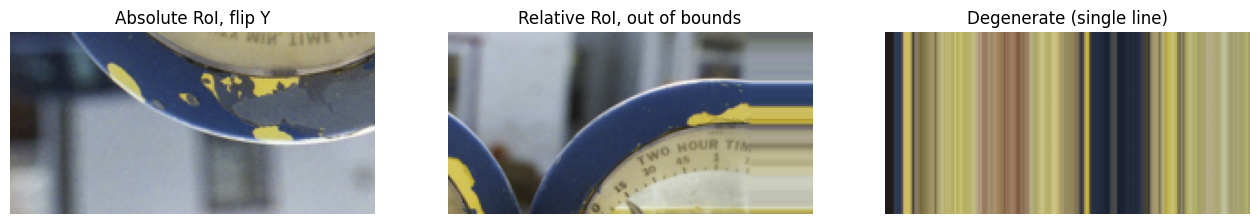

In [10]:
labels = ["Absolute RoI, flip Y", "Relative RoI, out of bounds", "Degenerate (single line)"]
show_images(*images, size=(16, 8), labels=labels, columns=3)

## Fused Flip

Resize can flip the image in one of two ways:
1. Specify RoI with `roi_start > roi_end`
2. Specify negative output size

If 1 and 2 coincide, flipping is cancelled.

In [11]:
width = 400
height = 200

images = (
    ndd.resize(image, size=[height, width], roi_start=[0, 100], roi_end=[300, 500]),
    ndd.resize(image, size=[height, width], roi_start=[0, 500], roi_end=[300, 100]),
    ndd.resize(image, size=[-height, width]),
    ndd.resize(image, size=[height, -width], roi_start=[0, 500], roi_end=[300, 100]),
)

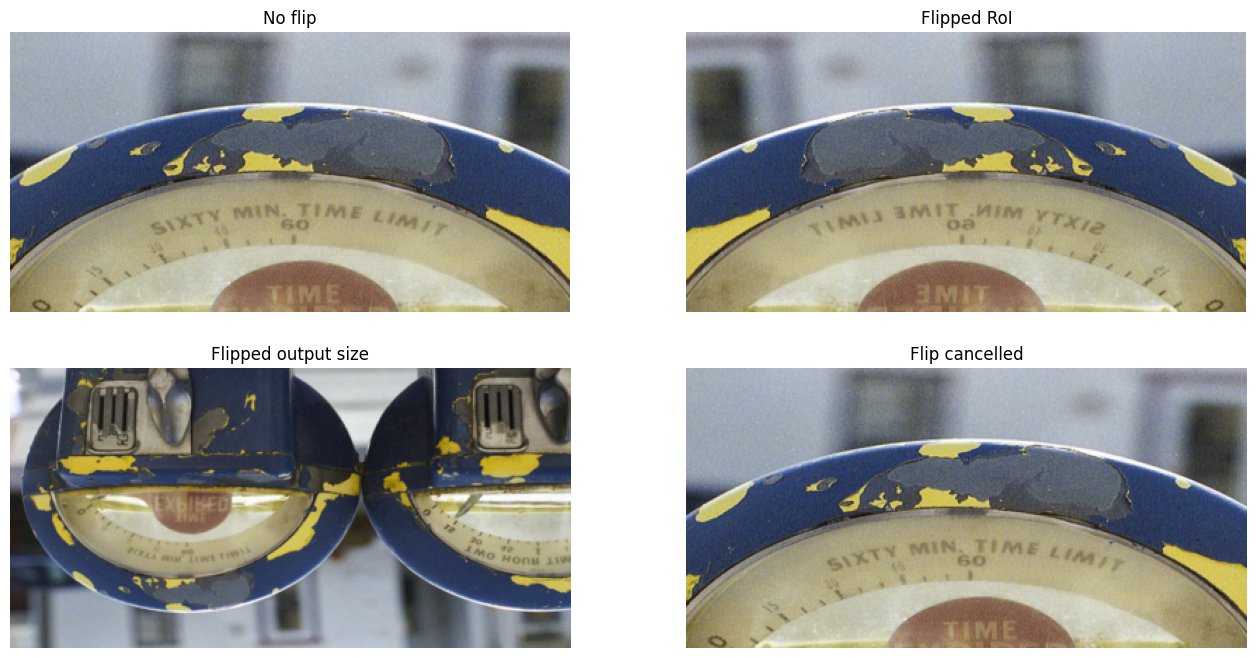

In [12]:
labels = ["No flip", "Flipped RoI", "Flipped output size", "Flip cancelled"]
show_images(*images, size=(16, 8), labels=labels)

## Input and Output Types

Resize can handle inputs of the following types:
- uint8
- int16
- uint16
- float

The output can be in float, regardless of input type.

The example below demonstrates how Resize handles negative values for INT16 and extended dynamic range for float.

In [13]:
width = 200
height = 100

# make some pixels negative
image_i16 = ndd.cast(image - 128, dtype=types.INT16)
image_u16 = ndd.cast(image, dtype=types.UINT16)
image_f32 = image / 256.0  # scale to 0..1 range

images = [
    ndd.resize(image, size=[height, width]),
    ndd.resize(image_i16, size=[height, width]) + 128,  # back to positive
    ndd.resize(image_u16, size=[height, width]),
    ndd.resize(image_f32, size=[height, width]) * 256,  # scale back for display
    ndd.resize(image, size=[height, width], dtype=types.FLOAT),
    ndd.resize(image_i16, size=[height, width], dtype=types.FLOAT) + 128,
    ndd.resize(image_u16, size=[height, width], dtype=types.FLOAT),
]

labels = [
    "input: uint8",
    "input: int16",
    "input: uint16",
    "input: float32",
    "input: uint8",
    "input: int16",
    "input: uint16",
]
for i, img in enumerate(images):
    labels[i] += "\noutput: {}".format(img.dtype)
show_images(*images, size=(16, 7), labels=labels, columns=4)

## Internal Conversion to `float`

When converting to `float`, the interpolation may result in fractional values, not representable in the input type. The example below demonstrates scaling a checkerboard with bilinear interpolation. With integer output, quantization artifacts are clearly visible.

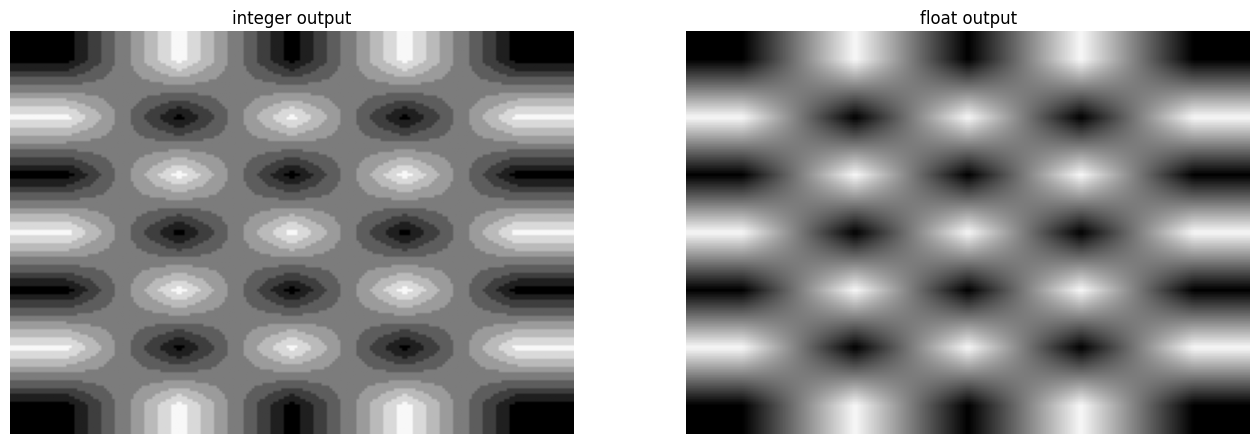

In [14]:
checkerboard = (
    (np.array([[1, 0, 1, 0, 1]]) ^ np.array([[1], [0], [1], [0], [1], [0], [1]]))
)[:, :, np.newaxis]
checkerboard = (checkerboard * np.array([[[8, 8, 8]]])).astype(np.uint8)

image = ndd.as_tensor(checkerboard, layout="HWC")

resized_int = ndd.resize(image, size=[150, 210]) * 31
resized_float = ndd.resize(image, size=[150, 210], dtype=types.FLOAT) * 31

show_images(resized_int, resized_float, size=(16, 6), labels=["integer output", "float output"])

## Subpixel Scale

If the output size is not integer - either because it was specified this way, or as an attempt to maintain aspect ratio - there are two ways to deal with the situation.

By default, subpixel scaling is used - i.e. the output canvas size of course needs to be integer, but the input RoI is adjusted to maintain original scaling factor.

This can be disabled by setting `subpixel_scale` to `False`, which adjusts the scaling factor to the rounded size. This may be important for applications for which maintaining the aspect ratio is critical at subpixel level.

The example below illustrates this subtle difference by scaling a small checkerboard pattern.

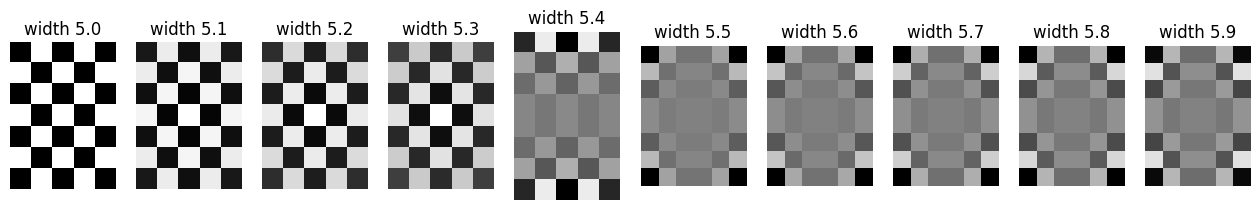

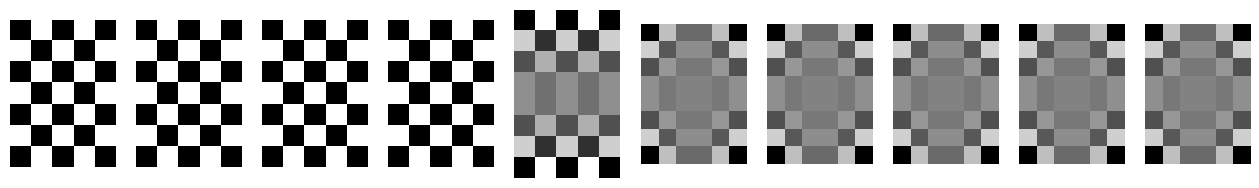

In [15]:
checkerboard = (
    (np.array([[1, 0, 1, 0, 1]]) ^ np.array([[1], [0], [1], [0], [1], [0], [1]])) * 255
).astype(np.uint8)[:, :, np.newaxis]
checkerboard = checkerboard * np.array([[[1, 1, 1]]], dtype=np.uint8)

image = ndd.as_tensor(checkerboard, layout="HWC")

# Generate outputs for different widths
widths = [checkerboard.shape[1] + i * 0.1 for i in range(10)]

subpixel = (ndd.pad(ndd.resize(image, resize_x=w), fill_value=255) for w in widths)
quantized = (
    ndd.pad(ndd.resize(image, resize_x=w, subpixel_scale=False), fill_value=255)
    for w in widths
)

labels = ["width {:.1f}".format(w) for w in widths]
show_images(*subpixel, size=(16, 10), labels=labels, columns=10)
show_images(*quantized, size=(16, 10), columns=10)

As we see, images in the top row (with subpixel scaling enabled) are changing gradually. In the bottom row, there are hard transitions between subsequent, quantized, output sizes.